New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/nyc-taxi-trip-duration"))

# Any results you write to the current directory are saved as output.

['nyc-taxi-trip-duration', 'nyctaxi-clean-test-data', 'nyctaxi-clean-train-data']
['test.csv', 'test', 'sample_submission', 'train', 'train.csv', 'sample_submission.csv']


In [4]:
# Import libraries
import datetime
import math

import geopy.distance

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Assess data

Let's first start by loading the training data and inspect it

In [5]:
train = pd.read_csv('../input/nyc-taxi-trip-duration/train.csv',
                   parse_dates=['pickup_datetime', 'dropoff_datetime'],
                   dtype={'store_and_fwd_flag':'category'})

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null category
trip_duration         1458644 non-null int64
dtypes: category(1), datetime64[ns](2), float64(4), int64(3), object(1)
memory usage: 112.7+ MB


In [7]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [8]:
train.shape

(1458644, 11)

In [9]:
train.describe(include='all')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id3122218,NaN,2016-03-04 08:07:34,2016-05-16 19:40:28,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


In [10]:
test = pd.read_csv('../input/nyc-taxi-trip-duration/test.csv',
                   parse_dates=['pickup_datetime'],
                   dtype={'store_and_fwd_flag':'category'})

In [11]:
test.describe(include='all')

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
count,625134,625134.000000,625134,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134
unique,625134,NaN,610581,NaN,NaN,NaN,NaN,NaN,2
top,id1667417,NaN,2016-02-04 19:54:06,NaN,NaN,NaN,NaN,NaN,N
freq,1,NaN,4,NaN,NaN,NaN,NaN,NaN,621704
first,NaN,NaN,2016-01-01 00:00:22,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:58,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534884,NaN,1.661765,-73.973614,40.750927,-73.973458,40.751816,NaN
std,NaN,0.498782,NaN,1.311293,0.073389,0.029848,0.072565,0.035824,NaN
min,NaN,1.000000,NaN,0.000000,-121.933128,37.389587,-121.933327,36.601322,NaN
25%,NaN,1.000000,NaN,1.000000,-73.991852,40.737392,-73.991318,40.736000,NaN


### Quality & Tidiness

#### Categorical column (store_and_fwd_flag)
* Use one hot encoding for this column

#### Datetime columns (pickup_datetime)
* datetime columns which are **pickup_datetime** should be split to 'month', 'week', 'dayofweek', 'hour' (We should not need to do this for and **dropoff_datetime** because they are likely to be the same and we already have the tripduration which we try to predict
* Apply MinMaxScaler to all new columns

#### Location columns (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
* To create a train data, create a new column **distance_km** to store a distance value in km computed from (pickup_longitude	pickup_latitude	dropoff_longitude dropoff_latitude) and drop those data that exceed .99 quantile in the train data to remove outlier. Note that we do not need to do this for the test data.
  * This decision was made after exploring the train data
* Find a distance between a pickup location and a dropoff location to **Time Square** and add new columns to capture this information
  * This decision was made to improve to experiment whether it can improve an accuracy of the prediction
  * Intuitively, trip duration for locations closer to a popular tourist location should have a longer trip duration because of a heavy traffic in the area
* Apply StandardScaler for the distance

#### Passenger count
* Apply MinMaxScaler to the **passenger_count**

#### Drop unused columns
* **id** column can be dropped because we do not need it in training
* **pickup_datetime** and **dropoff_datetime** must be dropped after all above are doneto train a model
* Original columns that are scaled in the previous steps will be dropped since we won't use it 

## Data Wrangling

Transform the original data to follow our requirements in the Quality & Tidiness section above

In [12]:
def create_datetime_columns(df, col_name, scaler=None):
    '''
    Create addtional datetime columns and scale them
    '''

    raw_data = pd.concat([df[col_name].dt.dayofweek,
                      df[col_name].dt.month,
                      df[col_name].dt.week,
                      df[col_name].dt.hour], axis=1)
    
    if not scaler:
        scaler = MinMaxScaler()
        scaler.fit(raw_data)
    
    scaled_data = scaler.transform(raw_data)

    df[col_name+ '_' + 'dayofweek'] = scaled_data[:, 0]
    df[col_name+ '_' + 'month'] = scaled_data[:, 1]
    df[col_name+ '_' + 'week'] = scaled_data[:, 2]
    df[col_name+ '_' + 'hour'] = scaled_data[:, 3]
        
    return df, scaler

In [13]:
def get_distance_km(row):
    '''
    Get a distance in kilometers between a pickup and dropoff locations of a given rows
    '''
    coords_1 = (row.pickup_latitude, row.pickup_longitude)
    coords_2 = (row.dropoff_latitude, row.dropoff_longitude)
    
    return geopy.distance.geodesic(coords_1, coords_2).km

In [14]:
def get_distance_pickup_to_timesquare_km(row):
    
    coords_timesquare = (40.7590, -73.9845)
    
    coords_pickup = (row.pickup_latitude, row.pickup_longitude)
    
    return geopy.distance.geodesic(coords_pickup, coords_timesquare).km

In [15]:
def get_distance_dropoff_to_timesquare_km(row):
    
    coords_timesquare = (40.7590, -73.9845)
    
    coords_dropoff = (row.dropoff_latitude, row.dropoff_longitude)
    
    return geopy.distance.geodesic(coords_dropoff, coords_timesquare).km

In [16]:
def transform_data(df, scalers=None, cleanData=False):
    
    if scalers:
        scaler_datetime = scalers['datetime']
        scaler_distance = scalers['distance']
        scaler_passenger_count = scalers['passenger_count']
    else:
        scaler_datetime = None
        scaler_distance = None
        scaler_passenger_count = None
    
    data_clean = df.copy()
    
    #### Categorical column (store_and_fwd_flag)
    # This column must be converted to a numerical value by 
    # using cat.codes and cast it to int
    data_clean = pd.concat([data_clean.drop('vendor_id', axis=1), 
                        pd.get_dummies(data_clean['vendor_id'], prefix='vendor_id')], axis=1)
    
    data_clean = pd.concat([data_clean.drop('store_and_fwd_flag', axis=1), 
                        pd.get_dummies(data_clean['store_and_fwd_flag'], prefix='store_and_fwd_flag')], axis=1)
    
    
    #### Datetime columns (pickup_datetime)
    # datetime columns which is **pickup_datetime**
    # should be split to 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'hour'
#     data_clean = create_datetime_columns(data_clean, 
#                                          ['pickup_datetime', 'dropoff_datetime'])
    # Only do get additional column for pickup_datetime should be enought because
    # They are typically on the same day
    data_clean, scaler_datetime = create_datetime_columns(data_clean, 'pickup_datetime', scaler=scaler_datetime)

    #### Location columns (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
    # Create a new column **distance_km** to store a distance value in km computed from (pickup_longitude	pickup_latitude	dropoff_longitude	dropoff_latitude)
    data_clean['distance_km'] = data_clean.apply(lambda row: get_distance_km(row), axis=1)
    data_clean['dist_pickup_to_timesquare'] = data_clean.apply(lambda row: get_distance_pickup_to_timesquare_km(row), axis=1)
    data_clean['dist_dropoff_to_timesquare'] = data_clean.apply(lambda row: get_distance_dropoff_to_timesquare_km(row), axis=1)

    raw_distance = pd.concat([data_clean['distance_km'],
                          data_clean['dist_pickup_to_timesquare'], 
                          data_clean['dist_dropoff_to_timesquare']], axis=1)
    
    if not scaler_distance:
        scaler_distance = StandardScaler()
        scaler_distance.fit(raw_distance)
    
    scaled_distance = scaler_distance.transform(raw_distance)
    
    data_clean['scaled_distance_km'] = scaled_distance[:, 0]
    data_clean['scaled_dist_pickup_to_timesquare'] = scaled_distance[:, 1]
    data_clean['scaled_dist_dropoff_to_timesquare'] = scaled_distance[:, 2]
    
    if cleanData:
        # After doing the exploratory analysis, I found that there are outliers in the dataset
        # (there are trips that have 1k km) that could potentially cause an unexpected behavior
        # Hence, remove those outlier data before proceeding         
        data_clean = data_clean[data_clean.distance_km < data_clean.distance_km.quantile(0.99)]
    
    
    #### Passenger count
    # Apply MinMaxScaler to the **passenger_count**
    data_passenger_count = np.array(data_clean['passenger_count']).reshape(-1, 1)
    
    if not scaler_passenger_count:
        scaler_passenger_count = MinMaxScaler()
        scaler_passenger_count.fit(data_passenger_count)

    scaled_passenger_count = scaler_passenger_count.transform(data_passenger_count)
    data_clean['scaled_passenger_count'] = scaled_passenger_count[:,0]
    
    #### Drop unused columns
    # **id** column can be dropped because we do not need it in training
    # **pickup_datetime** and **dropoff_datetime** must be dropped after all above are done

    data_clean = data_clean.drop(['id', 
                                  'pickup_datetime',
                                  'distance_km',
                                  'dist_pickup_to_timesquare',
                                  'dist_dropoff_to_timesquare',
                                  'passenger_count'
                                 ], axis=1)
    
    # Test data does not have dropof_datetime column. Hence, skip it
    if data_clean.columns.contains('dropoff_datetime'):
        data_clean = data_clean.drop(['dropoff_datetime'], axis=1)
        
    
    out_scalers = {'datetime': scaler_datetime, 
                   'distance': scaler_distance,
                   'passenger_count': scaler_passenger_count}
    
    return data_clean, out_scalers

In [17]:
# # Clean the train data
# # Comment it out and use the saved clean data instead if it is already created

# print('[{}] Start'.format(datetime.datetime.now()))

# %time data_clean, out_scalers = transform_data(train, cleanData=True)

# data_clean.reset_index().to_feather('data_clean')

In [18]:
# # We will use a saved clean data from the previous session here
data_clean = pd.read_feather('../input/nyctaxi-clean-train-data/data_clean')

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [19]:
data_clean.head()

,index,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_datetime_dayofweek,pickup_datetime_month,pickup_datetime_week,pickup_datetime_hour,scaled_distance_km,scaled_dist_pickup_to_timesquare,scaled_dist_dropoff_to_timesquare,scaled_passenger_count
0,0,-73.982155,40.767937,-73.964630,40.765602,455,0,1,1,0,0.000000,0.4,0.192308,0.739130,-0.451141,-0.340011,-0.257057,0.111111
1,1,-73.980415,40.738564,-73.999481,40.731152,663,1,0,1,0,1.000000,1.0,0.423077,0.000000,-0.379869,-0.140186,-0.022454,0.111111
2,2,-73.979027,40.763939,-74.005333,40.710087,2124,0,1,1,0,0.166667,0.0,0.038462,0.478261,0.683097,-0.385901,0.345403,0.111111
3,3,-74.010040,40.719971,-74.012268,40.706718,429,0,1,1,0,0.333333,0.6,0.250000,0.826087,-0.455452,0.256156,0.431148,0.111111
4,4,-73.973053,40.793209,-73.972923,40.782520,435,0,1,1,0,0.833333,0.4,0.211538,0.565217,-0.524423,0.112698,-0.108281,0.111111


In [20]:
# Inspect the output dataframe
data_clean.sample(20)

,index,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_datetime_dayofweek,pickup_datetime_month,pickup_datetime_week,pickup_datetime_hour,scaled_distance_km,scaled_dist_pickup_to_timesquare,scaled_dist_dropoff_to_timesquare,scaled_passenger_count
1340593,1354111,-74.011406,40.714947,-73.989372,40.773285,1011,1,0,1,0,0.166667,0.4,0.192308,0.695652,0.766975,0.342224,-0.286901,0.111111
406099,410102,-73.984520,40.721680,-73.984039,40.769741,1130,0,1,1,0,0.500000,0.2,0.115385,0.086957,0.440701,0.147648,-0.356078,0.111111
1016205,1026426,-73.944939,40.779045,-73.960426,40.777512,448,1,0,1,0,0.333333,0.4,0.192308,0.391304,-0.493862,0.127333,-0.092429,0.111111
1186339,1198285,-73.994209,40.751171,-74.015030,40.710152,1250,0,1,1,0,0.333333,0.8,0.326923,0.347826,0.335036,-0.311513,0.391482,0.111111
974120,983898,-73.984360,40.742905,-74.005554,40.748299,472,1,0,1,0,0.833333,0.6,0.250000,0.956522,-0.361512,-0.219289,-0.209277,0.222222
1401785,1415954,-73.965424,40.760086,-73.925217,40.768677,452,0,1,1,0,0.833333,0.6,0.230769,0.043478,0.019565,-0.246080,0.253749,0.222222
196955,198913,-73.993958,40.735439,-73.991524,40.719421,730,1,0,1,0,0.666667,0.0,0.057692,0.956522,-0.384066,-0.071674,0.147415,0.333333
527630,532865,-73.987213,40.755791,-74.014320,40.712994,1244,0,1,1,0,0.000000,1.0,0.423077,0.347826,0.426307,-0.431598,0.343301,0.333333
2407,2430,-73.989647,40.734425,-73.984863,40.742245,250,1,0,1,0,1.000000,0.2,0.115385,0.826087,-0.577728,-0.067334,-0.252402,0.111111
1347875,1361476,-73.978554,40.752895,-73.864166,40.830189,2030,1,0,1,0,0.500000,0.4,0.173077,1.000000,2.203592,-0.366220,1.457544,0.111111


In [21]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444057 entries, 0 to 1444056
Data columns (total 18 columns):
index                                1444057 non-null int64
pickup_longitude                     1444057 non-null float64
pickup_latitude                      1444057 non-null float64
dropoff_longitude                    1444057 non-null float64
dropoff_latitude                     1444057 non-null float64
trip_duration                        1444057 non-null int64
vendor_id_1                          1444057 non-null uint8
vendor_id_2                          1444057 non-null uint8
store_and_fwd_flag_N                 1444057 non-null uint8
store_and_fwd_flag_Y                 1444057 non-null uint8
pickup_datetime_dayofweek            1444057 non-null float64
pickup_datetime_month                1444057 non-null float64
pickup_datetime_week                 1444057 non-null float64
pickup_datetime_hour                 1444057 non-null float64
scaled_distance_km             

## Exploratory Data Analysis (EDA)

Before starting the modeling process, let's explore the data a little more to better understand it

### Correlation

In [22]:
corr = data_clean.corr()

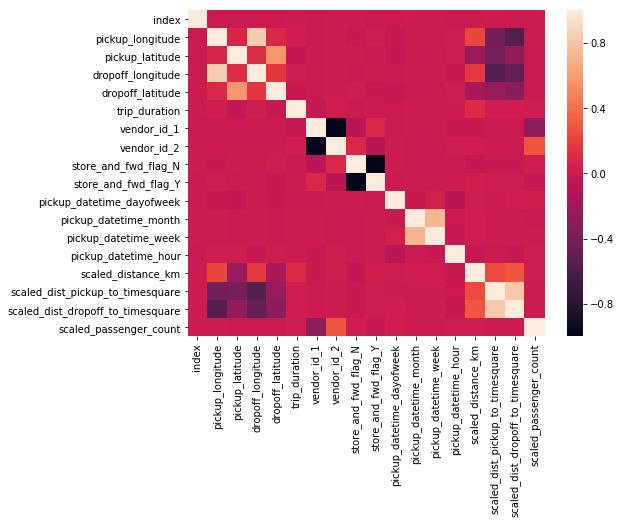

In [23]:
plt.figure(figsize=(8,6))

sns.heatmap(corr);

In [24]:
corr.style.background_gradient(cmap='coolwarm')

,index,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,vendor_id_1,vendor_id_2,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_datetime_dayofweek,pickup_datetime_month,pickup_datetime_week,pickup_datetime_hour,scaled_distance_km,scaled_dist_pickup_to_timesquare,scaled_dist_dropoff_to_timesquare,scaled_passenger_count
index,1,-0.000239646,-0.00133624,-0.000303192,-0.00172575,0.000412993,-0.000977028,0.000977028,0.00141637,-0.00141637,-0.000883758,0.00103798,0.000591828,-0.000382175,-0.000125466,0.00186154,0.00130194,0.000817802
pickup_longitude,-0.000239646,1,0.0775977,0.829887,0.0925877,0.0201264,-0.00681031,0.00681031,-0.00961444,0.00961444,-0.0159527,0.00442583,0.00598003,0.00801952,0.230589,-0.413782,-0.547661,0.000808011
pickup_latitude,-0.00133624,0.0775977,1,0.117175,0.566471,-0.0234673,-0.00376596,0.00376596,0.00735653,-0.00735653,-0.0343667,-0.00182754,-0.00543238,0.0153897,-0.228125,-0.396795,-0.263318,-0.00299033
dropoff_longitude,-0.000303192,0.829887,0.117175,1,0.163095,0.0117975,-0.00131311,0.00131311,-0.00714841,0.00714841,-0.00124305,0.00432317,0.00546114,-0.0212231,0.16965,-0.560186,-0.469985,-0.000966396
dropoff_latitude,-0.00172575,0.0925877,0.566471,0.163095,1,-0.0203858,-0.00478539,0.00478539,0.00929643,-0.00929643,-0.0230645,-0.000147684,-0.00295078,0.0120324,-0.158725,-0.244547,-0.307581,-0.00171111
trip_duration,0.000412993,0.0201264,-0.0234673,0.0117975,-0.0203858,1,-0.0198976,0.0198976,-0.00121697,0.00121697,-0.000474958,0.00617366,0.00433397,0.00353277,0.0948111,0.0220765,0.0208236,0.00818203
vendor_id_1,-0.000977028,-0.00681031,-0.00376596,-0.00131311,-0.00478539,-0.0198976,1,-1,-0.0791838,0.0791838,-0.00139601,0.00627594,0.00163551,-0.00933584,-0.00805227,-0.00525082,-0.00101146,-0.2885
vendor_id_2,0.000977028,0.00681031,0.00376596,0.00131311,0.00478539,0.0198976,-1,1,0.0791838,-0.0791838,0.00139601,-0.00627594,-0.00163551,0.00933584,0.00805227,0.00525082,0.00101146,0.2885
store_and_fwd_flag_N,0.00141637,-0.00961444,0.00735653,-0.00714841,0.00929643,-0.00121697,-0.0791838,0.0791838,1,-1,0.00394401,-0.000430808,-0.00105469,-0.00241757,-0.0270302,-0.00958554,-0.00955264,0.0220219
store_and_fwd_flag_Y,-0.00141637,0.00961444,-0.00735653,0.00714841,-0.00929643,0.00121697,0.0791838,-0.0791838,-1,1,-0.00394401,0.000430808,0.00105469,0.00241757,0.0270302,0.00958554,0.00955264,-0.0220219


In [25]:
# Get all column names
data_clean.columns.tolist()

['index',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'trip_duration',
 'vendor_id_1',
 'vendor_id_2',
 'store_and_fwd_flag_N',
 'store_and_fwd_flag_Y',
 'pickup_datetime_dayofweek',
 'pickup_datetime_month',
 'pickup_datetime_week',
 'pickup_datetime_hour',
 'scaled_distance_km',
 'scaled_dist_pickup_to_timesquare',
 'scaled_dist_dropoff_to_timesquare',
 'scaled_passenger_count']

## Use Default RandomForestRegressor Model

In [26]:
X = data_clean.drop(['trip_duration'], axis=1)
y = data_clean['trip_duration']

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [28]:
X_train.shape, X_valid.shape

((1155245, 17), (288812, 17))

In [29]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m, X_train, X_valid, y_train, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
m = RandomForestRegressor()

print('[{}] Start'.format(datetime.datetime.now()))

%time m.fit(X_train, y_train)


[2019-05-21 01:02:13.625549] Start


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
print('[{}] Start'.format(datetime.datetime.now()))


%time print_score(m, X_train, X_valid, y_train, y_valid)

Let's try to predict **trip_duration** of the **train****** data

In [ ]:
y_pred_train = m.predict(X_train)

Let's try to predict **trip_duration** of the **validation** data

In [ ]:
y_pred = m.predict(X_valid)

Now, let's find of Root Mean Squared Logarithmic Error of the predicted data.
This is an evaluation metrics defined in Kaggle

https://www.kaggle.com/c/nyc-taxi-trip-duration/overview/evaluation

In [ ]:
# From https://stackoverflow.com/questions/46202223/root-mean-log-squared-error-issue-with-scitkit-learn-ensemble-gradientboostingre
def rmsle(y, y0):
    return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))

Here is RMSLE of the train data

In [ ]:
rmsle(y_train, y_pred_train)

Here is RMSLE of the validation data

In [ ]:
rmsle(y_valid, y_pred)

### Just for fun

Let submit this simple model and submit it for the competition to see where we are in the leadership board!

Inspect the test data first. Notice that the **dropoff_datetime** and **trip_duration** columns are not included in this dataset!

In [ ]:
test.head()

In [ ]:
test.shape

We need to transform data before passing it to the model and this can be done by using the **transform_data** function

In [ ]:
# # Clean the test data
# # Comment it out and use the saved clean data instead if it is already created

# print('[{}] Start'.format(datetime.datetime.now()))

# %time test_clean, _ = transform_data(test, scalers=out_scalers)

# test_clean.reset_index().to_feather('test_clean')

Save the cleaned test data to a feather file so we can reuse it in the future

In [ ]:
# # We will use a saved clean data from the previous session here
test_clean = pd.read_feather('../input/nyctaxi-clean-test-data/test_clean')

Inspect data to ensure that we get all appropriate columns and no rows are removed

In [ ]:
test_clean.head()

In [ ]:
test_clean.info()

In [ ]:
test_clean.shape

Create features data

In [ ]:
X_sub = test_clean.copy()

Predict the trip duration

In [ ]:
y_sub = m.predict(X_sub)

Now, replace data in the **trip_duration** column of a dataframe created from the **sample_submission.csv** with our predicted data, and save it to a csv file for submission

In [ ]:
df_sub = pd.read_csv('../input/nyc-taxi-trip-duration/sample_submission.csv')

In [ ]:
df_sub.head()

In [ ]:
df_sub['trip_duration'] = y_sub
df_sub.head()

In [ ]:
df_sub.shape

In [ ]:
df_sub.to_csv('submission_default_scaling.csv', index=False)